In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers, models

In [2]:
df =pd.read_csv("dataset_file_directory.csv")

In [3]:
#differenttiat data for p01,p02,p03,p05,p06,p08,p09,p11,p16
p1_dataset =df[df['Participant'] == 'P01'] #select single person data
p2_dataset =df[df['Participant']== 'P02']
p3_dataset =df[df['Participant']== 'P03']
p5_dataset =df[df['Participant']== 'P05']
p6_dataset =df[df['Participant']== 'P06']
p8_dataset =df[df['Participant']== 'P08']
p11_dataset =df[df['Participant']== 'P11']
p16_dataset =df[df['Participant']== 'P16']



In [4]:
data_list=[p1_dataset,p2_dataset,p3_dataset,p5_dataset,p6_dataset,p8_dataset,p11_dataset,p16_dataset]
for i in data_list:
    
    num_classes = i['Label'].nunique()
    class_counts = i['Label'].value_counts()
    
    class_counts_df = class_counts.reset_index()
    class_counts_df.columns = ['Class', 'Count']
    print(class_counts_df)
    print(f"no of classes :{num_classes}")
    print("  ")


                    Class  Count
0                selftalk    564
1               delighted    357
2            dysregulated    212
3                  social    182
4              frustrated    150
5                 request    130
6      dysregulation-sick     74
7                bathroom     20
8  dysregulation-bathroom     18
9                    glee      1
no of classes :10
  
          Class  Count
0        social    247
1  affectionate    126
2    frustrated     56
3     delighted     43
4      laughter     38
5      selftalk     34
6       request     13
no of classes :7
  
          Class  Count
0  dysregulated    302
1       request     61
2      selftalk     55
3    frustrated     47
4     delighted     25
5       protest     20
6         laugh      8
7          glee      7
no of classes :8
  
          Class  Count
0      selftalk    286
1    frustrated    283
2     delighted    235
3  dysregulated    116
4         happy     61
5          help     24
6      laughter     13
7

In [5]:
#remove less significant class labels
p1_dataset =p1_dataset[~p1_dataset['Label'].isin([ 'dysregulation-bathroom','bathroom','glee'])]
# p2_dataset =p2_dataset[~p2_dataset['Label'].isin([ 'protest','more','tablet','dysregulated'])]
p3_dataset =p3_dataset[~p3_dataset['Label'].isin([ 'laugh','glee'])]
p5_dataset =p5_dataset[~p5_dataset['Label'].isin([ 'hunger','request','laughter'])]
p6_dataset =p6_dataset[~p6_dataset['Label'].isin([ 'dysregulated','affectionate','social'])]
p8_dataset =p8_dataset[~p8_dataset['Label'].isin([ 'protest','more','tablet','dysregulated'])]
p11_dataset =p11_dataset[~p11_dataset['Label'].isin(['greeting'])]
p16_dataset =p16_dataset[~p16_dataset['Label'].isin(['dysregulated','no','request'])]



In [6]:
#shuffle data

from sklearn.utils import shuffle
p1_datasets = shuffle(p1_dataset)
p2_datasets = shuffle(p2_dataset)
p3_datasets = shuffle(p3_dataset)
p5_datasets = shuffle(p5_dataset)
p6_datasets = shuffle(p6_dataset)
p8_datasets = shuffle(p8_dataset)
p11_datasets = shuffle(p11_dataset)
p16_datasets = shuffle(p16_dataset)

In [7]:
p6_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 4027 to 4237
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     560 non-null    object
 1   Participant  560 non-null    object
 2   Label        560 non-null    object
dtypes: object(3)
memory usage: 17.5+ KB


In [8]:
#feature extraction function for dataset

#************note skipping record that don't have correspondent audio file ******************

# Specify the directory where your Python script is located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
# Define the relative path to the WAV files directory
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

def extract_audiofeatures(dataset, features_list, labels_list):
    null_file=0
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None)  # sr=None to preserve the original sample rate

                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                # Calculate the mean of MFCCs along each feature dimension
    #             rms = librosa.feature.rms(y=audio_data)
    #             rms_mean = np.mean(rms)


                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                  # Concatenate RMS and MFCC features
    #             combined_features = np.concatenate((np.array([rms_mean]), mfccs_mean,chroma_mean,spectral_contrast_mean), axis=0)

                #combined features
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean))
                # Append the extracted features and label to the lists
                features_list.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file +=1
            print(f"Audio file not found: {wav_file_path}")
    print("Related audio file unfound count:",null_file)
# Now, features1 and labels1 should only contain data for audio files that exist


In [9]:
def extract_audio_features2(dataset,features_list,labels_list):
    null_file = 0
    
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None) 
                # Perform feature extraction (e.g., MFCCs)
                
               
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                

            # Calculate the mean of FFT features
                
                mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
                
                
                features_list.append(mel_spectrogram_mean)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file += 1
            print(f"Audio file not found: {wav_file_path}")

    print("Related audio files not found count:", null_file)

    return null_file


In [10]:

def extract_audio_features1(dataset,features_list,labels_list):
    null_file=0
   
    for index, row in dataset.iterrows():
        filename = row['Filename']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None)  # sr=None to preserve the original sample rate

                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                
                # Calculate Harmonic Ratio
#                 harmonic_ratio = librosa.effects.harmonic(audio_data)

#                 # Take the mean of the harmonic ratio to get a single value
#                 harmonic_ratio_mean = np.mean(harmonic_ratio)

                # Calculate Spectrogram as image-based features
                spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

                # Convert Spectrogram to decibels (dB)
                spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

                # Calculate mean values for each feature
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                spectrogram_db_mean = np.mean(spectrogram_db, axis=1)

                # Concatenate all features into a single feature vector
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean,spectrogram_db_mean,spectral_contrast_mean))

                # Append the extracted features and label to the lists
                features_list.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file +=1
            print(f"Audio file not found: {wav_file_path}")
    print("Related audio file unfound count:",null_file)


In [11]:
#feature extraction  call function
features1 = []
labels1 = []
null_file=0
extract_audio_features2(p1_datasets,features1,labels1)
P01_X= np.array(features1)
P01_y =np.array(labels1)


Related audio files not found count: 0


In [12]:
#model for p02 dataset

features2 = []
labels2 = []

extract_audio_features2(p2_datasets,features2,labels2)

P02_X=np.array(features2)
P02_y=np.array(labels2)



Related audio files not found count: 0


In [13]:
#model for p03 dataset

features3 = []
labels3 = []

extract_audio_features2(p3_datasets,features3,labels3)

P03_X=np.array(features3)
P03_y=np.array(labels3)


Related audio files not found count: 0


In [14]:
#model for p05 dataset

features5 = []
labels5 = []

extract_audio_features2(p5_datasets,features5,labels5)

P05_X=np.array(features5)
P05_y=np.array(labels5)


Related audio files not found count: 0


In [15]:
#model for p06 dataset

features6 = []
labels6 = []

extract_audio_features2(p6_datasets,features6,labels6)

P06_X=np.array(features6)
P06_y=np.array(labels6)


Related audio files not found count: 0


In [16]:
P06_X.shape

(560, 13)

In [17]:
#model for p08 dataset

features8 = []
labels8 = []

extract_audio_features2(p8_datasets,features8,labels8)

P08_X=np.array(features8)
P08_y=np.array(labels8)


Related audio files not found count: 0


In [18]:
#model for p11 dataset

features11 = []
labels11 = []

extract_audio_features2(p11_datasets,features11,labels11)

P11_X=np.array(features11)
P11_y=np.array(labels11)


Related audio files not found count: 0


In [19]:
#model for p16 dataset

features16 = []
labels16 = []

extract_audio_features2(p16_datasets,features16,labels16)

P16_X=np.array(features16)
P16_y=np.array(labels16)


Related audio files not found count: 0


In [20]:
print(P01_X.shape)
print(P02_X.shape)
print(P03_X.shape)
print(P05_X.shape)
print(P06_X.shape)
print(P08_X.shape)
print(P11_X.shape)
print(P16_X.shape)

(1669, 13)
(557, 13)
(510, 13)
(1005, 13)
(560, 13)
(1502, 13)
(363, 13)
(714, 13)


In [21]:
print(P01_y.shape)
print(P02_y.shape)
print(P03_y.shape)
print(P05_y.shape)
print(P06_y.shape)
print(P08_y.shape)
print(P11_y.shape)
print(P16_y.shape)

(1669,)
(557,)
(510,)
(1005,)
(560,)
(1502,)
(363,)
(714,)


In [22]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



label_encoder = LabelEncoder()
P01y_encoded = label_encoder.fit_transform(P01_y)
P02y_encoded = label_encoder.fit_transform(P02_y)
P03y_encoded = label_encoder.fit_transform(P03_y)
P05y_encoded = label_encoder.fit_transform(P05_y)
P06y_encoded = label_encoder.fit_transform(P06_y)
P08y_encoded = label_encoder.fit_transform(P08_y)
P11y_encoded = label_encoder.fit_transform(P11_y)
P16y_encoded = label_encoder.fit_transform(P16_y)

#split data into training and test se3
#check once all dataset features extracted or not

X_train_P01, X_test_P01, y_train_P01,y_test_P01 = train_test_split(P01_X, P01y_encoded,test_size=0.25, random_state=42)
X_train_P02, X_test_P02, y_train_P02,y_test_P02 = train_test_split(P02_X, P02y_encoded,test_size=0.25, random_state=42)
X_train_P03, X_test_P03, y_train_P03,y_test_P03 = train_test_split(P03_X, P03y_encoded,test_size=0.25, random_state=42)
X_train_P05, X_test_P05, y_train_P05,y_test_P05 = train_test_split(P05_X, P05y_encoded,test_size=0.25, random_state=42)
X_train_P06, X_test_P06, y_train_P06,y_test_P06 = train_test_split(P06_X, P06y_encoded,test_size=0.25, random_state=42)
X_train_P08, X_test_P08, y_train_P08,y_test_P08 = train_test_split(P08_X, P08y_encoded,test_size=0.25, random_state=42)
X_train_P11, X_test_P11, y_train_P11,y_test_P11 = train_test_split(P11_X, P11y_encoded,test_size=0.25, random_state=42)
X_train_P16, X_test_P16, y_train_P16,y_test_P16 = train_test_split(P16_X, P16y_encoded,test_size=0.25, random_state=42)

In [23]:
#check class

def check_class(y_train,y_test):
    unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
    unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

    # Compare the unique classes in both sets
    if np.array_equal(unique_classes_train, unique_classes_test):
        print("All classes are present in both the training and test sets.")
    else:
        print("Classes are not consistent between training and test sets.")
check_class(y_train_P01,y_test_P01)
check_class(y_train_P02,y_test_P02)
check_class(y_train_P03,y_test_P03)
check_class(y_train_P05,y_test_P05)
check_class(y_train_P06,y_test_P06)
check_class(y_train_P08,y_test_P08)
check_class(y_train_P11,y_test_P11)
check_class(y_train_P16,y_test_P16)


All classes are present in both the training and test sets.
All classes are present in both the training and test sets.
All classes are present in both the training and test sets.
All classes are present in both the training and test sets.
All classes are present in both the training and test sets.
All classes are present in both the training and test sets.
Classes are not consistent between training and test sets.
All classes are present in both the training and test sets.


In [24]:
#define cnn model



model_P01= models.Sequential([
    layers.Reshape((X_train_P01.shape[1], 1), input_shape=(X_train_P01.shape[1],)),
    
    # Add more convolutional layers
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    
    # Add more dense layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(7, activation='softmax')  # Two output classes
])
# Compile the model
model_P01.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
#model p02
model_P02= models.Sequential([
    layers.Reshape((X_train_P02.shape[1], 1), input_shape=(X_train_P02.shape[1],)),
    
    # Add more convolutional layers
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    
    # Add more dense layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(7, activation='softmax')  # Two output classes
])
# Compile the model
model_P02.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
#model P03
model_P03= models.Sequential([
    layers.Reshape((X_train_P03.shape[1], 1), input_shape=(X_train_P03.shape[1],)),
    
    # Add more convolutional layers
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    
    # Add more dense layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(6, activation='softmax')  # Two output classes
])
# Compile the model
model_P03.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
#model P05
model_P05= models.Sequential([
    layers.Reshape((X_train_P05.shape[1], 1), input_shape=(X_train_P05.shape[1],)),
    
    # Add more convolutional layers
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    
    # Add more dense layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(6, activation='softmax')  # Two output classes
])
# Compile the model
model_P05.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
#model6
model_P06= models.Sequential([
    layers.Reshape((X_train_P06.shape[1], 1), input_shape=(X_train_P06.shape[1],)),
    
    # Add more convolutional layers
    # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
    layers.Dense(5, activation='softmax')  # Two output classes
])
# Compile the model
model_P06.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
(X_train_P06.shape[1])

13

In [30]:
#model P08
model_P08= models.Sequential([
    layers.Reshape((X_train_P08.shape[1], 1), input_shape=(X_train_P08.shape[1],)),
    
    # Add more convolutional layers
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    
    # Add more dense layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(6, activation='softmax')  # Two output classes
])
# Compile the model
model_P08.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
#model p11

model_P11= models.Sequential([
    layers.Reshape((X_train_P11.shape[1], 1), input_shape=(X_train_P11.shape[1],)),
    
    # Add more convolutional layers
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    
    # Add more dense layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(6, activation='softmax')  # Two output classes
])
# Compile the model
model_P11.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
#model P016

model_P16= models.Sequential([
    layers.Reshape((X_train_P16.shape[1], 1), input_shape=(X_train_P16.shape[1],)),
    
    # Add more convolutional layers
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    
    # Add more dense layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(4, activation='softmax')  # Two output classes
])
# Compile the model
model_P16.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history_P01 = model_P01.fit(X_train_P01, y_train_P01, epochs=100, 
                   validation_split=0.2, 
                    batch_size=64)

Epoch 1/100
16/16 [==============================] - 1s 36ms/step - loss: 2.1498 - accuracy: 0.2160 - val_loss: 1.7725 - val_accuracy: 0.3426
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 1.8149 - accuracy: 0.2950 - val_loss: 1.7453 - val_accuracy: 0.3506
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 1.7783 - accuracy: 0.3100 - val_loss: 1.7557 - val_accuracy: 0.3147
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 1.7630 - accuracy: 0.2880 - val_loss: 1.7233 - val_accuracy: 0.3068
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 1.7277 - accuracy: 0.3000 - val_loss: 1.6749 - val_accuracy: 0.3586
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 1.6805 - accuracy: 0.3330 - val_loss: 1.6402 - val_accuracy: 0.3347
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 1.6596 - accuracy: 0.3220 - val_loss: 1.6071 - val_accuracy: 0.3785
Epoch 

In [34]:
history_P02 = model_P02.fit(X_train_P02, y_train_P02, epochs=100, 
                   validation_split=0.2, 
                    batch_size=32)

Epoch 1/100
11/11 [==============================] - 1s 45ms/step - loss: 2.0103 - accuracy: 0.3273 - val_loss: 1.5960 - val_accuracy: 0.4048
Epoch 2/100
11/11 [==============================] - 0s 12ms/step - loss: 1.7774 - accuracy: 0.3514 - val_loss: 1.5876 - val_accuracy: 0.4405
Epoch 3/100
11/11 [==============================] - 0s 12ms/step - loss: 1.7178 - accuracy: 0.4114 - val_loss: 1.5964 - val_accuracy: 0.4524
Epoch 4/100
11/11 [==============================] - 0s 12ms/step - loss: 1.6640 - accuracy: 0.4144 - val_loss: 1.5783 - val_accuracy: 0.4405
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 1.6589 - accuracy: 0.4354 - val_loss: 1.5668 - val_accuracy: 0.4405
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 1.6004 - accuracy: 0.4565 - val_loss: 1.5252 - val_accuracy: 0.4405
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 1.6192 - accuracy: 0.4264 - val_loss: 1.5354 - val_accuracy: 0.4524
Epoch 

In [35]:
history_P03 = model_P03.fit(X_train_P03, y_train_P03, epochs=100, 
                   validation_split=0.2, 
                    batch_size=50)

Epoch 1/100
7/7 [==============================] - 1s 70ms/step - loss: 1.9689 - accuracy: 0.4459 - val_loss: 1.6138 - val_accuracy: 0.5844
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 1.7500 - accuracy: 0.4525 - val_loss: 1.6094 - val_accuracy: 0.5974
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 1.6785 - accuracy: 0.5311 - val_loss: 1.5941 - val_accuracy: 0.6104
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 1.5546 - accuracy: 0.5541 - val_loss: 1.5557 - val_accuracy: 0.5974
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 1.5061 - accuracy: 0.5869 - val_loss: 1.5297 - val_accuracy: 0.5974
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 1.4501 - accuracy: 0.5902 - val_loss: 1.5008 - val_accuracy: 0.5974
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 1.4693 - accuracy: 0.5672 - val_loss: 1.4706 - val_accuracy: 0.5974
Epoch 8/100
7/7 [===

In [36]:
history_P05 = model_P05.fit(X_train_P05, y_train_P05, epochs=100, 
                   validation_split=0.2, 
                    batch_size=45)

Epoch 1/100
14/14 [==============================] - 1s 37ms/step - loss: 1.8160 - accuracy: 0.2326 - val_loss: 1.6174 - val_accuracy: 0.3775
Epoch 2/100
14/14 [==============================] - 0s 12ms/step - loss: 1.7062 - accuracy: 0.3123 - val_loss: 1.6352 - val_accuracy: 0.3444
Epoch 3/100
14/14 [==============================] - 0s 11ms/step - loss: 1.6698 - accuracy: 0.3189 - val_loss: 1.5981 - val_accuracy: 0.3907
Epoch 4/100
14/14 [==============================] - 0s 11ms/step - loss: 1.6063 - accuracy: 0.3223 - val_loss: 1.5884 - val_accuracy: 0.3841
Epoch 5/100
14/14 [==============================] - 0s 11ms/step - loss: 1.5900 - accuracy: 0.3306 - val_loss: 1.5739 - val_accuracy: 0.3907
Epoch 6/100
14/14 [==============================] - 0s 11ms/step - loss: 1.5783 - accuracy: 0.3156 - val_loss: 1.5692 - val_accuracy: 0.3974
Epoch 7/100
14/14 [==============================] - 0s 11ms/step - loss: 1.5573 - accuracy: 0.3439 - val_loss: 1.5533 - val_accuracy: 0.3642
Epoch 

In [37]:
history_P06 = model_P06.fit(X_train_P06, y_train_P06, epochs=100, 
                   validation_split=0.2, 
                    batch_size=25)

Epoch 1/100
14/14 [==============================] - 1s 37ms/step - loss: 2.9584 - accuracy: 0.2560 - val_loss: 1.6728 - val_accuracy: 0.3095
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 1.8676 - accuracy: 0.2738 - val_loss: 1.5436 - val_accuracy: 0.3214
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 1.5884 - accuracy: 0.3571 - val_loss: 1.5226 - val_accuracy: 0.4524
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 1.5892 - accuracy: 0.3720 - val_loss: 1.5091 - val_accuracy: 0.4286
Epoch 5/100
14/14 [==============================] - 0s 10ms/step - loss: 1.5628 - accuracy: 0.3810 - val_loss: 1.4841 - val_accuracy: 0.3929
Epoch 6/100
14/14 [==============================] - 0s 10ms/step - loss: 1.5678 - accuracy: 0.3423 - val_loss: 1.4755 - val_accuracy: 0.4524
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 1.4647 - accuracy: 0.3899 - val_loss: 1.4772 - val_accuracy: 0.3690
Epoch 

In [38]:
history_P08 = model_P08.fit(X_train_P08, y_train_P08, epochs=100, 
                   validation_split=0.2, 
                    batch_size=64)

Epoch 1/100
15/15 [==============================] - 1s 35ms/step - loss: 1.5889 - accuracy: 0.4644 - val_loss: 1.2368 - val_accuracy: 0.4956
Epoch 2/100
15/15 [==============================] - 0s 12ms/step - loss: 1.3743 - accuracy: 0.4789 - val_loss: 1.2103 - val_accuracy: 0.5133
Epoch 3/100
15/15 [==============================] - 0s 12ms/step - loss: 1.2735 - accuracy: 0.5478 - val_loss: 1.1544 - val_accuracy: 0.5177
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: 1.2254 - accuracy: 0.5478 - val_loss: 1.0878 - val_accuracy: 0.5177
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: 1.1426 - accuracy: 0.5900 - val_loss: 1.0480 - val_accuracy: 0.5354
Epoch 6/100
15/15 [==============================] - 0s 12ms/step - loss: 1.1207 - accuracy: 0.5867 - val_loss: 1.0721 - val_accuracy: 0.5487
Epoch 7/100
15/15 [==============================] - 0s 11ms/step - loss: 1.1284 - accuracy: 0.5744 - val_loss: 1.0604 - val_accuracy: 0.5531
Epoch 

In [39]:
history_P11 = model_P11.fit(X_train_P11, y_train_P11, epochs=100, 
                   validation_split=0.2, 
                    batch_size=42)

Epoch 1/100
6/6 [==============================] - 1s 87ms/step - loss: 2.0048 - accuracy: 0.3641 - val_loss: 1.6555 - val_accuracy: 0.6000
Epoch 2/100
6/6 [==============================] - 0s 17ms/step - loss: 1.7822 - accuracy: 0.4700 - val_loss: 1.6023 - val_accuracy: 0.6000
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 1.8212 - accuracy: 0.4562 - val_loss: 1.5618 - val_accuracy: 0.6000
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 1.6545 - accuracy: 0.5207 - val_loss: 1.5274 - val_accuracy: 0.6000
Epoch 5/100
6/6 [==============================] - 0s 16ms/step - loss: 1.6411 - accuracy: 0.5300 - val_loss: 1.4912 - val_accuracy: 0.6000
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 1.5688 - accuracy: 0.5253 - val_loss: 1.4750 - val_accuracy: 0.6000
Epoch 7/100
6/6 [==============================] - 0s 16ms/step - loss: 1.5137 - accuracy: 0.5576 - val_loss: 1.4463 - val_accuracy: 0.6000
Epoch 8/100
6/6 [===

In [40]:
history_P16 = model_P16.fit(X_train_P16, y_train_P16, epochs=50, 
                   validation_split=0.2, 
                    batch_size=16)

Epoch 1/50
27/27 [==============================] - 1s 20ms/step - loss: 1.4071 - accuracy: 0.4720 - val_loss: 1.2430 - val_accuracy: 0.5701
Epoch 2/50
27/27 [==============================] - 0s 7ms/step - loss: 1.1954 - accuracy: 0.5958 - val_loss: 1.0695 - val_accuracy: 0.6168
Epoch 3/50
27/27 [==============================] - 0s 8ms/step - loss: 1.0343 - accuracy: 0.6402 - val_loss: 1.0464 - val_accuracy: 0.6262
Epoch 4/50
27/27 [==============================] - 0s 7ms/step - loss: 1.0070 - accuracy: 0.6495 - val_loss: 1.0125 - val_accuracy: 0.6449
Epoch 5/50
27/27 [==============================] - 0s 7ms/step - loss: 0.9706 - accuracy: 0.6612 - val_loss: 1.0213 - val_accuracy: 0.6449
Epoch 6/50
27/27 [==============================] - 0s 7ms/step - loss: 0.9371 - accuracy: 0.6495 - val_loss: 1.0044 - val_accuracy: 0.6542
Epoch 7/50
27/27 [==============================] - 0s 7ms/step - loss: 0.8901 - accuracy: 0.6939 - val_loss: 0.9933 - val_accuracy: 0.6449
Epoch 8/50
27/27 [=

In [41]:
test_loss_P01, test_accuracy_P01 = model_P01.evaluate(X_test_P01, y_test_P01)
print(f"Test accuracy for model_P01: {test_accuracy_P01 * 100:.2f}%")
test_loss_P02, test_accuracy_P02 = model_P02.evaluate(X_test_P02, y_test_P02)
print(f"Test accuracy for model_P02: {test_accuracy_P02 * 100:.2f}%")
test_loss_P03, test_accuracy_P03 = model_P03.evaluate(X_test_P03, y_test_P03)
print(f"Test accuracy for model_P03: {test_accuracy_P03 * 100:.2f}%")
test_loss_P05, test_accuracy_P05 = model_P05.evaluate(X_test_P05, y_test_P05)
print(f"Test accuracy for model_P05: {test_accuracy_P05 * 100:.2f}%")
test_loss_P06, test_accuracy_P06 = model_P06.evaluate(X_test_P06, y_test_P06)
print(f"Test accuracy for model_P06: {test_accuracy_P06 * 100:.2f}%")
test_loss_P08, test_accuracy_P08 = model_P08.evaluate(X_test_P08, y_test_P08)
print(f"Test accuracy for model_P08: {test_accuracy_P08 * 100:.2f}%")
test_loss_P11, test_accuracy_P11 = model_P11.evaluate(X_test_P11, y_test_P11)
print(f"Test accuracy for model_P11: {test_accuracy_P11 * 100:.2f}%")
test_loss_P16, test_accuracy_P16 = model_P16.evaluate(X_test_P16, y_test_P16)
print(f"Test accuracy for model_P16: {test_accuracy_P16 * 100:.2f}%")



14/14 [==============================] - 0s 3ms/step - loss: 1.4727 - accuracy: 0.5502
Test accuracy for model_P01: 55.02%
5/5 [==============================] - 0s 4ms/step - loss: 2.1230 - accuracy: 0.4500
Test accuracy for model_P02: 45.00%
4/4 [==============================] - 0s 4ms/step - loss: 1.2082 - accuracy: 0.6484
Test accuracy for model_P03: 64.84%
8/8 [==============================] - 0s 4ms/step - loss: 2.2789 - accuracy: 0.3730
Test accuracy for model_P05: 37.30%
5/5 [==============================] - 0s 3ms/step - loss: 1.6616 - accuracy: 0.4000
Test accuracy for model_P06: 40.00%
12/12 [==============================] - 0s 3ms/step - loss: 1.8914 - accuracy: 0.5878
Test accuracy for model_P08: 58.78%
3/3 [==============================] - 0s 4ms/step - loss: 2.4269 - accuracy: 0.5275
Test accuracy for model_P11: 52.75%
6/6 [==============================] - 0s 4ms/step - loss: 1.0937 - accuracy: 0.6592
Test accuracy for model_P16: 65.92%


In [42]:
P01_y_pred=model_P01.predict(X_test_P01)
P02_y_pred=model_P02.predict(X_test_P02)
P03_y_pred=model_P03.predict(X_test_P03)
P05_y_pred=model_P05.predict(X_test_P05)
P06_y_pred=model_P06.predict(X_test_P06)
P08_y_pred=model_P08.predict(X_test_P08)
P11_y_pred=model_P11.predict(X_test_P11)
P16_y_pred=model_P16.predict(X_test_P16)



6/6 [==============================] - 0s 3ms/step


In [43]:
y_pred_labels_P01 = np.argmax(P01_y_pred, axis=1)
y_pred_labels_P02 = np.argmax(P02_y_pred, axis=1)
y_pred_labels_P03 = np.argmax(P03_y_pred, axis=1)
y_pred_labels_P05 = np.argmax(P05_y_pred, axis=1)
y_pred_labels_P06 = np.argmax(P06_y_pred, axis=1)
y_pred_labels_P08 = np.argmax(P08_y_pred, axis=1)
y_pred_labels_P11 = np.argmax(P11_y_pred, axis=1)
y_pred_labels_P16 = np.argmax(P16_y_pred, axis=1)

In [44]:
from sklearn.metrics import confusion_matrix

confusion_P01 = confusion_matrix(y_test_P01, y_pred_labels_P01)
confusion_P02 = confusion_matrix(y_test_P02, y_pred_labels_P02)
confusion_P03 = confusion_matrix(y_test_P03, y_pred_labels_P03)
confusion_P05 = confusion_matrix(y_test_P05, y_pred_labels_P05)
confusion_P06 = confusion_matrix(y_test_P06, y_pred_labels_P06)
confusion_P08 = confusion_matrix(y_test_P08, y_pred_labels_P08)
confusion_P11 = confusion_matrix(y_test_P11, y_pred_labels_P11)
confusion_P16 = confusion_matrix(y_test_P16, y_pred_labels_P16)

In [45]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already calculated the confusion matrix as 'confusion'
# The matrix is expected to be in the format returned by the confusion_matrix function
def show_confusionmatrix(confusion,dataset,person):
    
    # Calculate the sum of true positives, true negatives, false positives, and false negatives for each class
    class_sums = np.sum(confusion, axis=1)

    # Normalize the confusion matrix by dividing each entry by the respective class sum
    normalized_confusion = confusion / class_sums[:, np.newaxis]

    # Extract unique class labels from the 'Label' column
    class_labels = dataset['Label'].unique()

    # Convert class labels to a list
    class_labels = list(class_labels)

    # Create a heatmap to visualize the normalized confusion matrix (without percentages)
    plt.figure(figsize=(4, 3))
    sns.heatmap(normalized_confusion, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Normalized confusion matrix for {person}')
    plt.show()
    



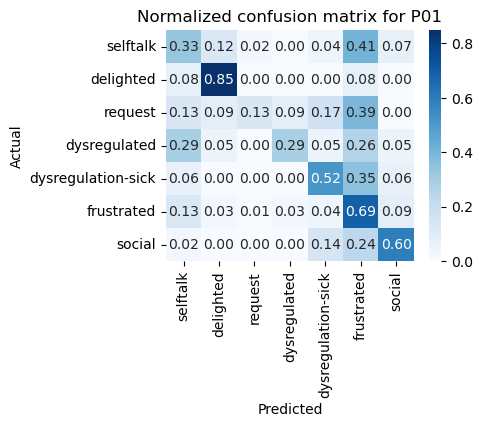

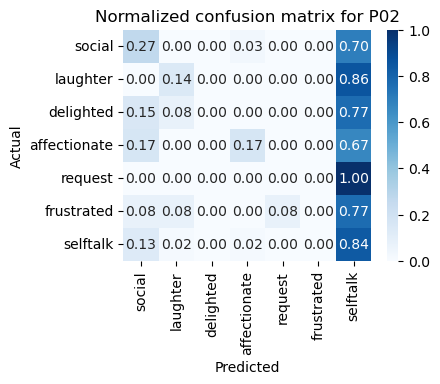

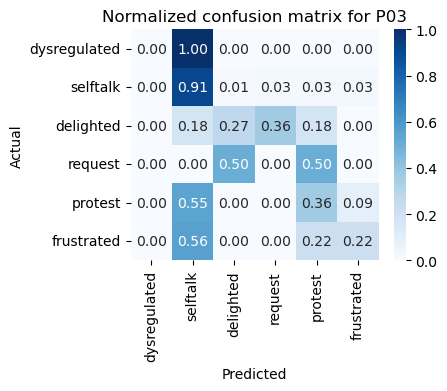

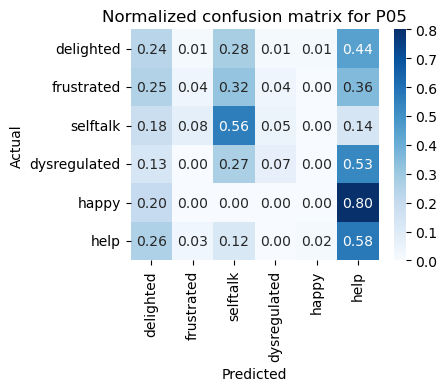

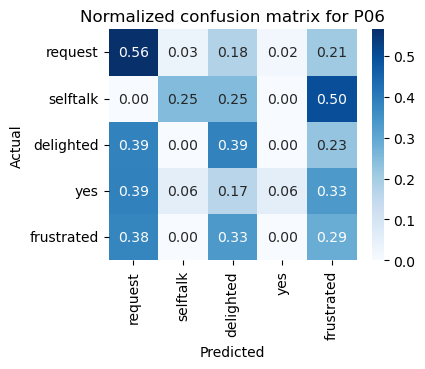

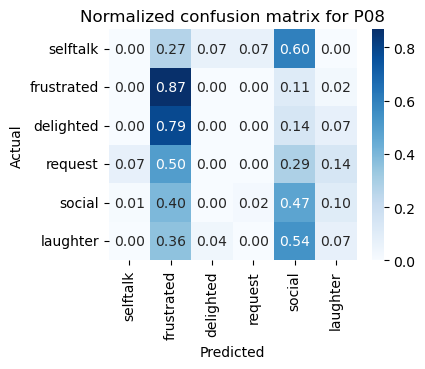

C:\Users\pawan\AppData\Local\Temp\ipykernel_1460\142619717.py:15: RuntimeWarning: invalid value encountered in divide
  normalized_confusion = confusion / class_sums[:, np.newaxis]


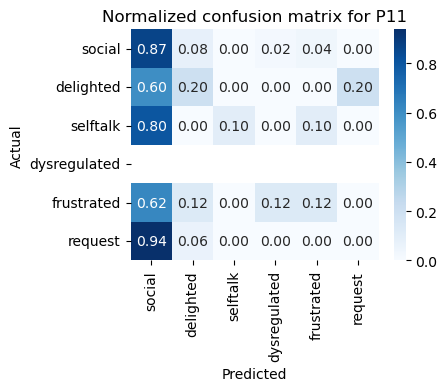

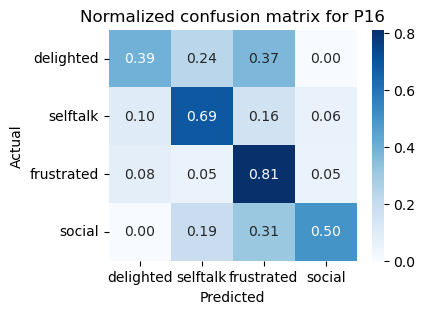

In [46]:
#show confusion matrix to related person dataset

stack_confusion = [confusion_P01, confusion_P02, confusion_P03, confusion_P05, confusion_P06, confusion_P08,
                   confusion_P11,confusion_P16]
dataset_list = [p1_datasets, p2_datasets, p3_datasets, p5_datasets, p6_datasets, p8_datasets, p11_datasets, p16_datasets]
person=['P01','P02','P03','P05','P06','P08','P11','P16']
for i in range(len(stack_confusion)):
    show_confusionmatrix(stack_confusion[i], dataset_list[i],person[i])


In [47]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1score_P01 = f1_score(y_test_P01, y_pred_labels_P01,average='weighted')
f1score_P02 = f1_score(y_test_P02, y_pred_labels_P02,average='weighted')
f1score_P03 = f1_score(y_test_P03, y_pred_labels_P03,average='weighted')
f1score_P05 = f1_score(y_test_P05, y_pred_labels_P05,average='weighted')
f1score_P06 = f1_score(y_test_P06, y_pred_labels_P06,average='weighted')
f1score_P08 = f1_score(y_test_P08, y_pred_labels_P08,average='weighted')
f1score_P11 = f1_score(y_test_P11, y_pred_labels_P11,average='weighted')
f1score_P16 = f1_score(y_test_P16, y_pred_labels_P16,average='weighted')
print("F1 Score:", f1score_P01)
print("F1 Score:", f1score_P02)
print("F1 Score:", f1score_P03)
print("F1 Score:", f1score_P05)
print("F1 Score:", f1score_P06)
print("F1 Score:", f1score_P08)
print("F1 Score:", f1score_P11)
print("F1 Score:", f1score_P16)

F1 Score: 0.5315581259873117
F1 Score: 0.36552045765452057
F1 Score: 0.6108439867424243
F1 Score: 0.3413479355256515
F1 Score: 0.39253798832746195
F1 Score: 0.5414790914864962
F1 Score: 0.44557525807525816
F1 Score: 0.6493063911689085


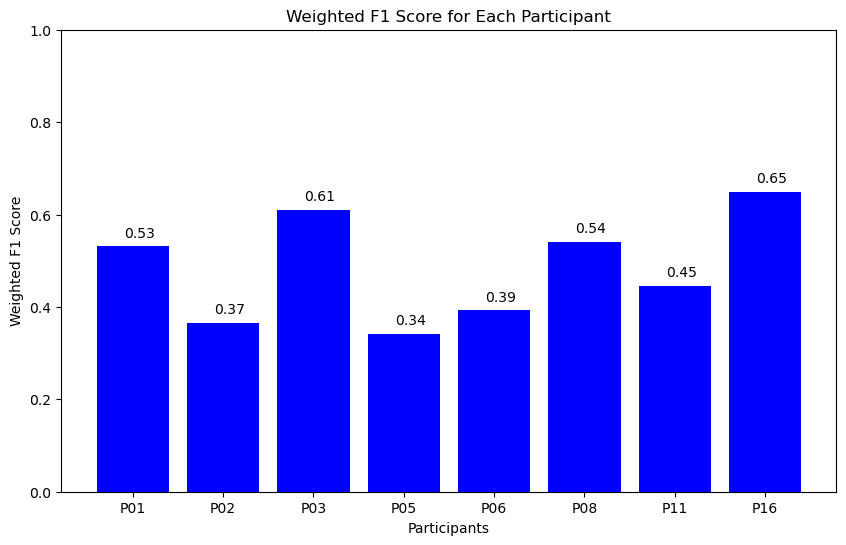

In [48]:
import matplotlib.pyplot as plt

# F1 scores for each participant and their corresponding labels
f1_scores = [f1score_P01, f1score_P02, f1score_P03, f1score_P05, f1score_P06, f1score_P08, f1score_P11, f1score_P16]
participants = ["P01", "P02", "P03", "P05", "P06", "P08", "P11", "P16"]

# Plot the F1 scores
plt.figure(figsize=(10, 6))
bars = plt.bar(participants, f1_scores, color='blue')
plt.xlabel('Participants')
plt.ylabel('Weighted F1 Score')
plt.title('Weighted F1 Score for Each Participant')
plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1

# Display the F1 scores over the bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{score:.2f}', fontsize=10)

plt.show()


In [49]:
#hyper parameter tuning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

# def build_model(hp):
#     model = keras.Sequential()
#     model.add(layers.Reshape((X_train_P06.shape[1], 1), input_shape=(X_train_P06.shape[1],)))
    
#     # Tune the number of filters for Conv1D
#     hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
#     model.add(layers.Conv1D(hp_filters, 3, activation='relu'))
    
#     model.add(layers.MaxPooling1D(2))
#     model.add(layers.Flatten())
    
#     # Tune the number of units in the Dense layer
#     hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
#     model.add(layers.Dense(hp_units, activation='relu'))
    
#     model.add(layers.Dense(5, activation='softmax'))
    
#     # Tune the learning rate for the optimizer
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model
def build_model_P11(hp):
    model = keras.Sequential()
    model.add(layers.Reshape((X_train_P11.shape[1], 1), input_shape=(X_train_P11.shape[1],)))
    
    # Define the number of convolutional layers as a hyperparameter
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)
    
    for i in range(num_conv_layers):
        # Tune the number of filters and kernel size for each convolutional layer
        num_filters = hp.Int(f'num_filters_{i}', min_value=32, max_value=256, step=32)
        kernel_size = hp.Int(f'kernel_size_{i}', min_value=3, max_value=5, step=1)
        
        model.add(layers.Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
        model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Flatten())
    
    # Define the number of dense layers as a hyperparameter
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)
    
    for i in range(num_dense_layers):
        # Tune the number of units for each dense layer
        num_units = hp.Int(f'num_units_{i}', min_value=64, max_value=512, step=64)
        
        model.add(layers.Dense(num_units, activation='relu'))
        model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    
    model.add(layers.Dense(6, activation='softmax'))
    
    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
tuner = RandomSearch(
    build_model_P11,
    objective='val_accuracy',  # Choose the metric to optimize
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='my_tuning_dir',  # Directory to store results
    project_name='audio_classification'
)
tuner.search(X_train_P11, y_train_P11,
             epochs=50,
             validation_split=0.2,
             batch_size=34)
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_model_P11(best_hp)




Using TensorFlow backend
Reloading Tuner from my_tuning_dir\audio_classification\tuner0.json


In [50]:

# best_model.fit(X_train_P11, y_train_P11, epochs=50, batch_size=34, validation_split=0.2)

# Make predictions on the test data
y_pred = best_model.predict(X_test_P11)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test_P11, y_pred_classes)

print("Confusion Matrix:")
print(confusion)
test_loss, test_accuracy = best_model.evaluate(X_test_P11, y_test_P11)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

3/3 [==============================] - 0s 5ms/step
Confusion Matrix:
[[ 0  0 27 20  0  5]
 [ 0  0  1  3  0  1]
 [ 0  0  6  4  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  5  2  0  1]
 [ 0  0  9  6  0  1]]
3/3 [==============================] - 0s 5ms/step - loss: 1.9856 - accuracy: 0.0769
Test accuracy: 7.69%


In [51]:
X_test_P11.shape


(91, 13)

In [52]:
import keras_tuner as kt
from IPython.display import clear_output 
from tensorflow import keras
from tensorflow.keras import layers

def build_model_P06(hp):
    model = keras.Sequential()
    model.add(layers.Reshape((X_train_P06.shape[1], 1), input_shape=(X_train_P06.shape[1],)))
    
    # Define the number of convolutional layers as a hyperparameter
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)
    
    for i in range(num_conv_layers):
        # Tune the number of filters and kernel size for each convolutional layer
        num_filters = hp.Int(f'num_filters_{i}', min_value=32, max_value=256, step=32)
        kernel_size = hp.Int(f'kernel_size_{i}', min_value=3, max_value=5, step=1)
        
        model.add(layers.Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
        model.add(layers.MaxPooling1D(2))
    
    model.add(layers.Flatten())
    
    # Define the number of dense layers as a hyperparameter
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)
    
    for i in range(num_dense_layers):
        # Tune the number of units for each dense layer
        num_units = hp.Int(f'num_units_{i}', min_value=64, max_value=512, step=64)
        
        model.add(layers.Dense(num_units, activation='relu'))
        model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    
    model.add(layers.Dense(5, activation='softmax'))
    
    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define a tuner
tuner = kt.Hyperband(build_model_P06,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                    
                     directory='hyperband',
                     project_name='model_P06_tuning')

# Define a callback to clear the previous runs
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        clear_output(wait=True)

# Perform the hyperparameter search
for _ in range(10):
    tuner.search(X_train_P06, y_train_P06, epochs=30, validation_split=0.2, callbacks=[ClearTrainingOutput()])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from hyperband\model_P06_tuning\tuner0.json


In [ ]:
#

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tensorflow import keras
from tensorflow.keras import layers

# Define the create_model function for the CNN
def create_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Load your dataset (you can use your data loading code here)
# df = pd.read_csv("dataset_file_directory.csv")
test_percentage = 0.40
# df20 = df.sample(frac=test_percentage, random_state=42)
df20=p1_datasets.copy()

# Define the directory where audio files are located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

# Define a function to extract audio features (you can use your feature extraction code here)
def extract_audio_features(dataset):
    features_list = []
    labels_list = []
    for index, row in dataset.iterrows():
        filename = row['Filename']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None)  # sr=None to preserve the original sample rate

                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
               
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
            
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean))
                # Append the extracted features and label to the lists
                features_list.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file +=1
            print(f"Audio file not found: {wav_file_path}")

    return np.array(features_list), np.array(labels_list)

# Filter out labels that are not common in the training data
# train_labels = set(df20['Label'].unique())
# df20 = df20[df20['Label'].isin(train_labels)]

# Extract audio features from your dataset
X, y = extract_audio_features1(df20)

# Define LOSO cross-validation with session stratification
logo = LeaveOneGroupOut()

# Initialize a list to store F1 scores
f1_scores = []

# Encode labels using LabelEncoder after filtering labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Iterate over participants using LOSO cross-validation
for train_index, test_index in logo.split(X, y_encoded, groups=df20['Participant']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Define the input shape and number of classes based on your data
    input_shape = X_train.shape[1]
    num_classes = len(train_labels)
    
    # Create the CNN model
    model = create_model(input_shape, num_classes)
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=42, validation_split=0.2, verbose=1)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate and print the F1 score for the session
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print("F1 Score:", f1)

    # Append the F1 score to the list
    f1_scores.append(f1)

# Calculate and print the mean F1 score across sessions
mean_f1_score = np.mean(f1_scores)
print("Mean F1 Score:", mean_f1_score)


In [ ]:
from tensorflow.keras.layers import LSTM

model1 = models.Sequential([
    layers.Reshape((X_train_P06.shape[1], 1), input_shape=(X_train_P06.shape[1],)),
    
    # Replace Convolutional Layers with LSTM Layers
    LSTM(64, return_sequences=True),
    LSTM(128, return_sequences=True),
    LSTM(256),
    
    # Add more dense layers if needed
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(7, activation='softmax')
])
model1.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history_P1 = model1.fit(X_train_P06, y_train_P06, epochs=50,
                            validation_split=0.2,
                            batch_size=32)


In [ ]:
test_loss_1, test_accuracy_1 = model1.evaluate(X_test_P06, y_test_P06)
print(f"Test accuracy for model_P01: {test_accuracy_1 * 100:.2f}%")

P1_y_pred = model1.predict(X_test_P06)
y_pred_labels_P01 = np.argmax(P1_y_pred, axis=1)


In [ ]:
from tensorflow.keras.layers import GRU

model_P1 = models.Sequential([
    layers.Reshape((X_train_P06.shape[1], 1), input_shape=(X_train_P06.shape[1],)),
    
    # Replace Convolutional Layers or LSTM Layers with GRU Layers
    GRU(64, return_sequences=True),
    GRU(128, return_sequences=True),
    GRU(256),
    
    # Add more dense layers if needed
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(7, activation='softmax')
])
model_P1.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history_P1 = model_P1.fit(X_train_P06, y_train_P06, epochs=10,
                            validation_split=0.2,
                            batch_size=42)


In [ ]:
test_loss_P1, test_accuracy_p1 = model_P1.evaluate(X_test_P06, y_test_P06)
print(f"Test accuracy for model_P01: {test_accuracy_p1 * 100:.2f}%")

In [ ]:
# Define the DNN model with feature fusion
modeld = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(4096, activation='relu'),  # Spectrogram features
    layers.Dense(13, activation='relu'),    # MFCC features
    layers.Dense(1, activation='linear'),   # Harmonic Ratio feature (you may need to adjust this)
    layers.Concatenate(),  # Concatenate all features
    layers.Dense(1024, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile the model
modeld.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
modeld.fit(X_traind, y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded))